In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [21]:
#Look if the distribution is uniform
#The loss should converge to 0. how?
#make line first

# Number of data points
num_points = 1000

# Generate random angles uniformly between 0 and 2π
theta = np.linspace(0, np.pi/2, num_points)

# Compute (x, y) coordinates
x = np.cos(theta)
y = np.sin(theta)

# Stack into a data array
data = np.stack([x, y], axis=1).astype(np.float32)

# Convert to PyTorch tensors
data_tensor = torch.tensor(data, device=device)

# Create a dataset and data loader
dataset = TensorDataset(data_tensor)
batch_size = 128
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



[tensor([[1.0000, 0.0000],
        [1.0000, 0.0016],
        [1.0000, 0.0031],
        [1.0000, 0.0047],
        [1.0000, 0.0063],
        [1.0000, 0.0079],
        [1.0000, 0.0094],
        [0.9999, 0.0110],
        [0.9999, 0.0126],
        [0.9999, 0.0142]])]


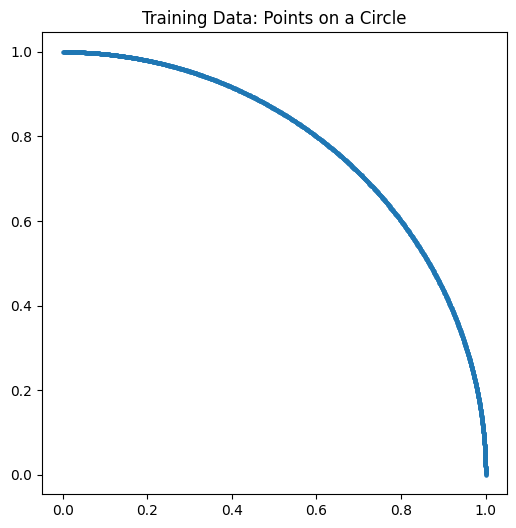

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=5)
plt.axis('equal')
plt.title('Training Data: Points on a Circle')
plt.show()

In [10]:
class EnergyModel(nn.Module):
    
    def __init__(self):
        super(EnergyModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        energy = self.net(x)
        return energy

In [29]:
class Sampler:
    
    def __init__(self, model, sample_size, device='cpu', max_len=8192):
        super().__init__()
        self.model = model
        self.sample_size = sample_size
        self.max_len = max_len
        self.device = device

        # Generate points in the interval [0,1]
        self.examples = [torch.rand((2,), device=self.device) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=0.1):

        # n_new is the number of points that are generated anew, the rest come from last iteration
        n_new = np.random.binomial(self.sample_size, 0.05)
        
        rand_points = (torch.rand((n_new, 2), device=self.device))

        # Select k=self.sample_size - n_new points from last iteration (self.examples)
        old_points = torch.stack(random.choices(self.examples, k=self.sample_size - n_new))

        inp_points = torch.cat([rand_points, old_points], dim=0).detach().to(self.device)

        out_points = Sampler.generate_samples(self.model, inp_points, steps=steps, step_size=step_size).to(self.device)

        # Update the last iteration points with the current iteration ones
        # Place points on the CPU to save GPU memory
        self.examples = list(inp_points.to(torch.device("cpu"))) + self.examples

        # If the points saved are too many discard the old ones
        self.examples = self.examples[:self.max_len]
        
        return out_points


    @staticmethod
    def generate_samples(model, inp_points, steps=60, step_size=0.1):
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_points.requires_grad = True

        # Generate a noise vector outside the loop so that we don't have to allocate memory 
        # each time we start a new loop iteration
        noise = torch.randn(inp_points.shape, device=device)

        for _ in range(steps):

            # the "_" means that this is an in-place operation. We are just modifying the noise vector
            # without allocating new memory
            noise.normal_(0, 0.01)

            '''
            Option 1:
            '''
            inp_points.data.add_(noise.data)

            energy = -model(inp_points)
            energy.sum().backward()
            inp_points.grad.data.clamp_(-0.03, 0.03)

            inp_points.data.add_(-step_size * inp_points.grad.data)
            inp_points.grad.detach_()
            inp_points.grad.zero_()
            '''
            inp_points = inp_points + noise
            print(inp_points.requires_grad)
            
            # Since the models compute -E(x) and we want inp_points_energy to be E(x) we need to change sign to the output of model()
            inp_points_energy = -model(inp_points)
            inp_points_energy.sum().backward()
            inp_points.grad.clamp_(-0.03, 0.03)  # Stabilize gradients

            inp_points = inp_points - step_size * inp_points.grad

            # Detatch grads from the computational graph and zero them
            inp_points.grad.detach_()
            inp_points.grad.zero_()
            '''

        for p in model.parameters():
            p.requires_grad = True
        model.train()

        return inp_points

In [68]:
class Trainer:
    def __init__(self, dataset, lr=1e-3, batch_size=128, num_epochs=100, 
                 sampler_steps=60, sampler_step_size=0.1, sampler_eval_steps=200, sampler_eval_step_size=0.1,
                 reg_coeff=1e-4, device='cpu'):

        self.device = device
        
        self.batch_size = batch_size
        self.data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        self.reg_coeff = reg_coeff
        
        self.num_epochs = num_epochs
        self.model = EnergyModel()

        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.sampler_steps = sampler_steps
        self.sampler_step_size = sampler_step_size
        self.sampler_eval_steps = sampler_eval_steps
        self.sampler_eval_step_size = sampler_eval_step_size
        self.sampler = Sampler(self.model, sample_size=self.batch_size, device=self.device)

        self.contrastive_divergence_losses = []

    def train(self):
        self.model.to(self.device)
        
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_contrastive_divergence_loss = 0.0
            
            for real_data in self.data_loader:
                real_data = real_data[0].to(self.device)
                fake_data = self.sampler.sample_new_exmps(steps=self.sampler_steps, step_size=self.sampler_step_size)
                all_data = torch.cat([real_data, fake_data], dim=0)
                
                self.optimizer.zero_grad()
                
                real_energy, fake_energy = self.model(all_data).chunk(2, dim=0)

                # Energy-based loss
                constrastive_divergence_loss = fake_energy.mean() - real_energy.mean()
                regularization_loss = self.reg_coeff * (real_energy ** 2 + fake_energy ** 2).mean()
                loss = constrastive_divergence_loss + regularization_loss
                
                loss.backward()
                
                self.optimizer.step()

                total_contrastive_divergence_loss += constrastive_divergence_loss

            avg_contrastive_divergence_loss = total_contrastive_divergence_loss / len(self.data_loader)
            self.contrastive_divergence_losses.append(avg_contrastive_divergence_loss.item())

            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {loss.item():.4f}")
                print(f"Epoch [{epoch+1}/{self.num_epochs}], regularization_loss: {regularization_loss:.4f}")
                print(f"Epoch [{epoch+1}/{self.num_epochs}], Constrastive divergence Loss: {constrastive_divergence_loss:.4f}")


    def plot_contrastive_divergence_loss(self):
        plt.plot(self.contrastive_divergence_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Contrastive Divergence Loss')
        plt.title('Contrastive Divergence Loss Over Training')
        plt.show()

    def plot_generated_vs_real_samples(self, num_samples=100):
        # Generate new samples using the sampler
        generated_samples = self.sampler.sample_new_exmps(steps=self.sampler_eval_steps, step_size=self.sampler_eval_step_size)
        generated_samples = generated_samples[:num_samples].cpu().detach().numpy()

        # Get real samples from the dataset
        real_samples = next(iter(self.data_loader))[0][:num_samples].cpu().detach().numpy()

        # Plot real and generated samples
        plt.figure(figsize=(8, 6))
        plt.scatter(real_samples[:, 0], real_samples[:, 1], color='blue', alpha=0.5, label='Real Samples')
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], color='red', alpha=0.5, label='Generated Samples')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Generated Samples vs Real Samples')
        plt.legend()
        plt.show()
                

In [69]:
trainer = Trainer(dataset, lr=1e-3, batch_size=128, num_epochs=200, 
                 sampler_steps=60, sampler_step_size=0.1, reg_coeff=1e-4, device='cpu')

In [70]:
trainer.train()

Epoch [1/200], Loss: 0.0006
Epoch [1/200], regularization_loss: 0.0000
Epoch [1/200], Constrastive divergence Loss: 0.0006
Epoch [2/200], Loss: -0.0023
Epoch [2/200], regularization_loss: 0.0000
Epoch [2/200], Constrastive divergence Loss: -0.0023
Epoch [11/200], Loss: 0.0075
Epoch [11/200], regularization_loss: 0.0000
Epoch [11/200], Constrastive divergence Loss: 0.0075
Epoch [21/200], Loss: 0.0060
Epoch [21/200], regularization_loss: 0.0000
Epoch [21/200], Constrastive divergence Loss: 0.0060
Epoch [31/200], Loss: 0.0115
Epoch [31/200], regularization_loss: 0.0000
Epoch [31/200], Constrastive divergence Loss: 0.0115
Epoch [41/200], Loss: 0.0127
Epoch [41/200], regularization_loss: 0.0000
Epoch [41/200], Constrastive divergence Loss: 0.0127
Epoch [51/200], Loss: -0.0042
Epoch [51/200], regularization_loss: 0.0000
Epoch [51/200], Constrastive divergence Loss: -0.0042
Epoch [61/200], Loss: -0.0287
Epoch [61/200], regularization_loss: 0.0000
Epoch [61/200], Constrastive divergence Loss: 

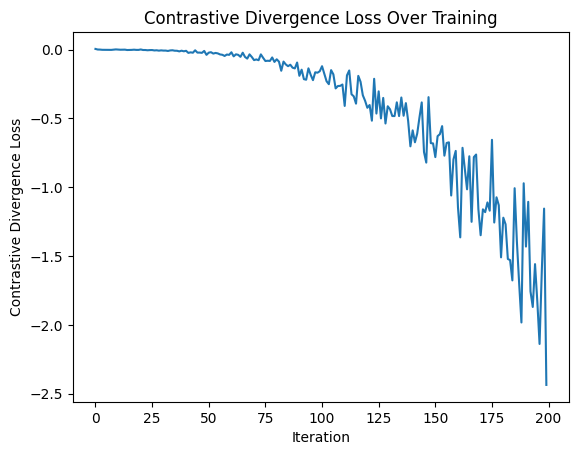

In [71]:
trainer.plot_contrastive_divergence_loss()

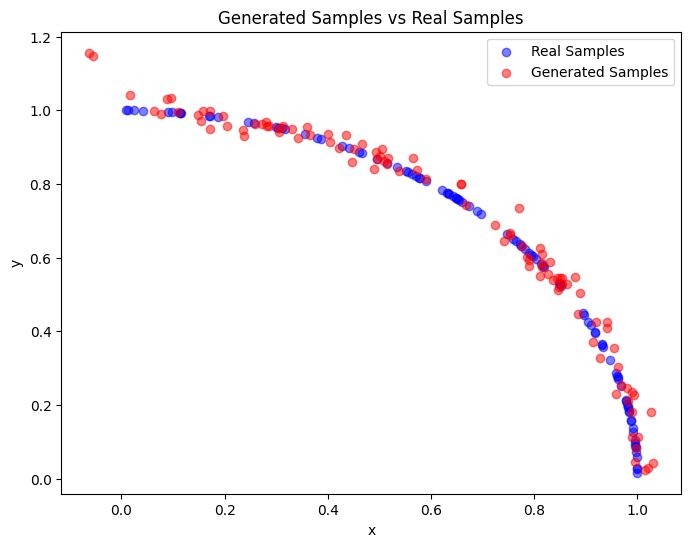

In [72]:
trainer.plot_generated_vs_real_samples()